In [137]:
#%pip install ipywidgets

In [138]:

# Initial imports
import numpy as np
import torch


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import pandas as pd
from sklearn.model_selection import train_test_split
# check pytorch version
print("PyTorch version:", torch.__version__)
# use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


#importing the required library for lime 
# install shap
#pip install shap
import shap



PyTorch version: 1.11.0+cu113
device: cpu


## Carga del modelo 

Como Pytorch guarda las variables del modelo y los pesos y en el modelo en su totalidad hemos cogido la clase definida en el notebook principal. 

In [154]:
import torch.nn as nn
class TitanicSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 64)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(32, 16)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(16, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        relu_out1 = self.relu1(lin1_out)
        relu_out2 = self.relu2(self.linear2(relu_out1))
        relu_out3 = self.relu3(self.linear3(relu_out2))
        return self.softmax(self.linear4(relu_out3))
    
    def predict(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        elif isinstance(x, torch.Tensor):
            x = x.float()
            
        x = x.view(x.size(0), -1)
        output = self.forward(x)
        predicted_probs = torch.softmax(output, dim=1)
        return predicted_probs


    
    def predict_lime(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        elif isinstance(x, torch.Tensor):
            x = x.float()

        x = x.view(x.size(0), -1)
        output = self.forward(x)
        predicted_probs = torch.softmax(output, dim=1)
        _, predicted_labels = torch.max(predicted_probs, 1)
        return predicted_probs.detach().numpy()
    

Observamos que la carga del modelo ha sido un exito. 

In [155]:
model_shap = TitanicSimpleNNModel()
model_shap.load_state_dict(torch.load('../Main Notebook/titanic_fcnn.pt'))
model_shap.eval()

TitanicSimpleNNModel(
  (linear1): Linear(in_features=12, out_features=64, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=32, out_features=16, bias=True)
  (relu3): ReLU()
  (linear4): Linear(in_features=16, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

## Cargamos los datos del dataset de entrada

En el notebook principal se han procesado los datos y una vez procesados se han guardado en un csv para eviatar volver a hacer las transformaciones necesarias. 

In [141]:
# Update path to dataset here.
dataset_path = "../Main Notebook/titanic_data.csv"
# Read dataset from csv file.
titanic_data = pd.read_csv(dataset_path)

In [156]:
#Split data into training features and labels
X, y = titanic_data.loc[:, titanic_data.columns != 'Survived'], titanic_data['Survived']

from sklearn.model_selection import train_test_split
# split data into train and test sets
seed = 7
test_size = 0.4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

Como se puede observar a continuacion el model esta perfectamnete cargado y se han obtenido las probabilidades para posterior implementacion en el model agnositco de SHAP. 

In [157]:
X_train_t = torch.from_numpy((X_train.to_numpy()).astype(float)).type(torch.FloatTensor) # Para convertir datos enteros y booleanos
y_train_t = torch.from_numpy(y_train.to_numpy())
X_test_t = torch.from_numpy((X_test.to_numpy()).astype(float)).type(torch.FloatTensor) # Para convertir datos enteros y booleanos
y_test_t = torch.from_numpy(y_test.to_numpy())

## Implementacion de SHAP


En las siguientes celdas se ha implementado SHAP.

In [144]:
#https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Multioutput%20Regression%20SHAP.html#Get-SHAP-Values-and-Plots
# print the JS visualization code to the notebook
shap.initjs()

Current Label Shown: PassengerId



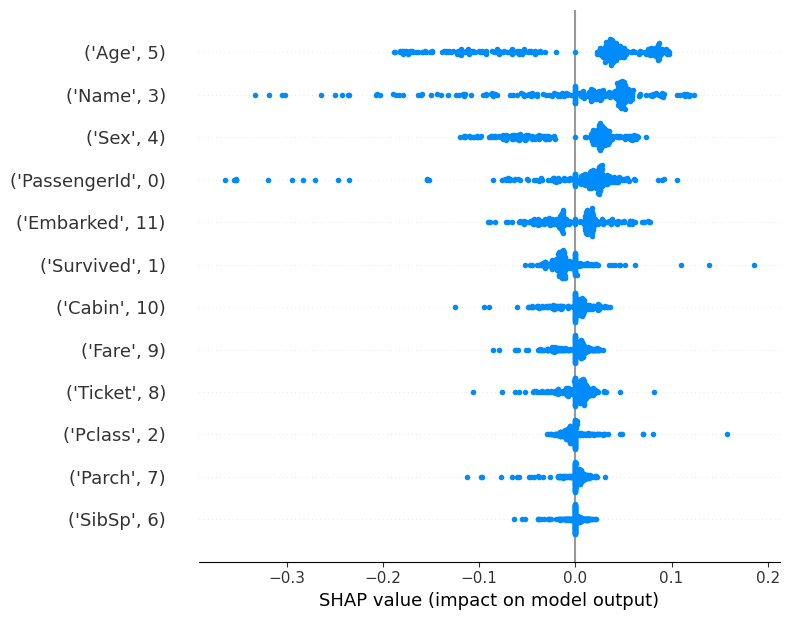

In [145]:
# print the JS visualization code to the notebook
shap.initjs()

print(f'Current Label Shown: {list_of_labels[current_label.value]}\n')

shap.summary_plot(shap_values = shap_values[current_label.value],
                  features = tuple_of_labels
                  )

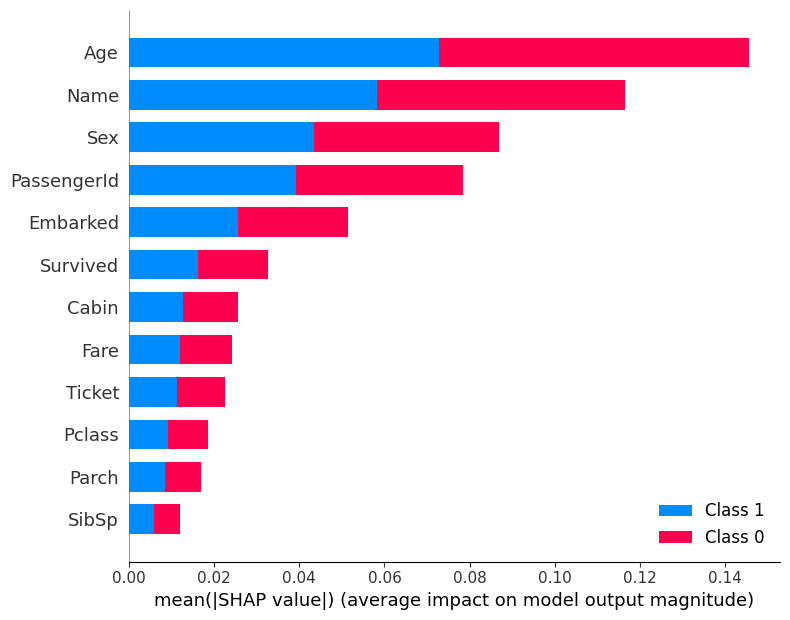

In [146]:


shap.summary_plot(shap_values = shap_values,
                  features = list_of_labels
                  )

In [147]:

shap.force_plot(explainer.expected_value[0], shap_values[0], test_features)

In [148]:

shap.force_plot(explainer.expected_value[0], shap_values[0], test_features)

In [149]:
explainer = shap.KernelExplainer(model = model_shap.predict_lime, data = test_features, link = "identity")

Using 268 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [150]:
# Set the index of the specific example to explain
X_idx = 0

shap_value_single = explainer.shap_values(X = test_features[X_idx:X_idx+1,:], nsamples = 100)

  0%|          | 0/1 [00:00<?, ?it/s]

In [151]:
test_features[X_idx:X_idx+1,:]

array([[36.    ,  0.    ,  0.    , 26.2875,  0.    ,  1.    ,  0.    ,
         0.    ,  1.    ,  1.    ,  0.    ,  0.    ]])

In [152]:
# print the JS visualization code to the notebook
shap.initjs()

print(f'Current label Shown: {list_of_labels[current_label.value]}')

shap.force_plot(base_value = explainer.expected_value[current_label.value],
                shap_values = shap_value_single[current_label.value],
                features = list_of_labels
                )

Current label Shown: PassengerId


In [153]:
# Note: We are limiting to the first 50 training examples since it takes time to calculate the full number of sampels
shap_values = explainer.shap_values(X = test_features[0:50,:], nsamples = 100)

  0%|          | 0/50 [00:00<?, ?it/s]